<a href="https://colab.research.google.com/github/FabioMMaia/LLMs/blob/main/RAG_estudos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai

In [2]:
!pip install pypdf

In [3]:
!pip install langchain

In [4]:
!pip install docarray

In [5]:
!pip install tiktoken

In [6]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

In [7]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANG_CHAIN_KEY'

In [28]:
# https://ufrb.edu.br/auditoria/images/Manual_da_Auditoria_Interna_-_atualizado_2018.pdf
# https://iiabrasil.org.br/korbilload/upl/ippf/downloads/normasinternaci-ippf-00000001-02042018191815.pdf

In [9]:
# prompt: mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
with open("/content/drive/MyDrive/Projeto ML/2024/LLMs_RAGs_estudo/openai_key.txt", "r") as f:
  openai_key = f.read()

os.environ['OPENAI_API_KEY'] = openai_key


#Perguntas

- o que deve constar no relatorio final de auditoria?
- o que é assunção de risco?
- quais são os tipos de papel de trabalho?
- como deve ser a apresentação gráfica?



# gpt-3.5-turbo

In [42]:
llm_name = "gpt-3.5-turbo"

In [43]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever (changed "similarity" to "max_marginal_relevance")
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0),
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa


In [52]:
import panel as pn
pn.extension()
import param


class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])

    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        # self.loaded_file = "/content/drive/MyDrive/Projeto ML/2024/LLMs_RAGs_estudo/normasinternaci-ippf-00000001-02042018191815.pdf"
        self.loaded_file = "/content/drive/MyDrive/Projeto ML/2024/LLMs_RAGs_estudo/Manual_da_Auditoria_Interna_-_atualizado_2018.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)

    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return
        rlist=[pn.Row(pn
                      .pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return


In [55]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp)

jpg_pane = pn.pane.Image( '/content/drive/MyDrive/Projeto ML/2024/LLMs_RAGs_estudo/convchain.png')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# Chatbot Aud')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
            [4] Row(align='center')
                [0] Button(button_type='success', name='Print', width=100)
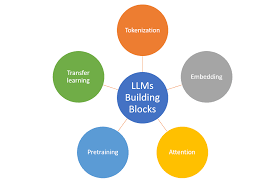

<ipython-input-52-7534429ed7d5>:43: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))


In [56]:
dashboard

# gpt-4-turbo

In [47]:
llm_name = "gpt-4-turbo"

def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever (changed "similarity" to "max_marginal_relevance")
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0),
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa

In [48]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp)

jpg_pane = pn.pane.Image( '/content/drive/MyDrive/Projeto ML/2024/LLMs_RAGs_estudo/convchain.png')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# Chatbot Aud')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
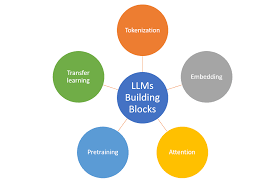

<ipython-input-44-a7994ccf1b20>:40: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
<ipython-input-44-a7994ccf1b20>:40: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
<ipython-input-44-a7994ccf1b20>:40: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
<ipython-input-44-a7994ccf1b20>:40: PanelDeprecationWarning: 'style' is deprecated and will be removed in version 1.4, use 'styles' instead.
  pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))


In [50]:
dashboard